参考资料：

https://www.kaggle.com/manojkumarmaruthi/house-price-prediction-using-decisiontree

rmse 是评价指标。

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

In [121]:
train = pd.read_csv('./input/train.csv')
test  = pd.read_csv('./input/test.csv')

In [122]:
train.shape

(1460, 81)

In [123]:
test.shape

(1459, 80)

删除一些没有用的特征。

In [124]:
train.drop(
    ['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'],
    axis=1,
    inplace=True)

In [125]:
train.drop(
    [
        'MSSubClass', 'MSZoning', 'Street', 'Utilities', 'LotShape',
        'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'YearRemodAdd',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenQual', 'GarageCond', 'Functional',
        'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
        'GarageCars', 'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
    ],
    axis=1,
    inplace=True)

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
LotFrontage     1201 non-null float64
LotArea         1460 non-null int64
OverallQual     1460 non-null int64
YearBuilt       1460 non-null int64
GrLivArea       1460 non-null int64
KitchenAbvGr    1460 non-null int64
TotRmsAbvGrd    1460 non-null int64
GarageArea      1460 non-null int64
SalePrice       1460 non-null int64
dtypes: float64(1), int64(8)
memory usage: 102.7 KB


填充 LotFrontage 字段的缺失值。

In [127]:
train['LotFrontage'].groupby(train['OverallQual'] == 1).mean()

OverallQual
False    70.066667
True     50.000000
Name: LotFrontage, dtype: float64

In [128]:
train["LotFrontage"] = train.groupby("OverallQual")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [129]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
LotFrontage     1460 non-null float64
LotArea         1460 non-null int64
OverallQual     1460 non-null int64
YearBuilt       1460 non-null int64
GrLivArea       1460 non-null int64
KitchenAbvGr    1460 non-null int64
TotRmsAbvGrd    1460 non-null int64
GarageArea      1460 non-null int64
SalePrice       1460 non-null int64
dtypes: float64(1), int64(8)
memory usage: 102.7 KB


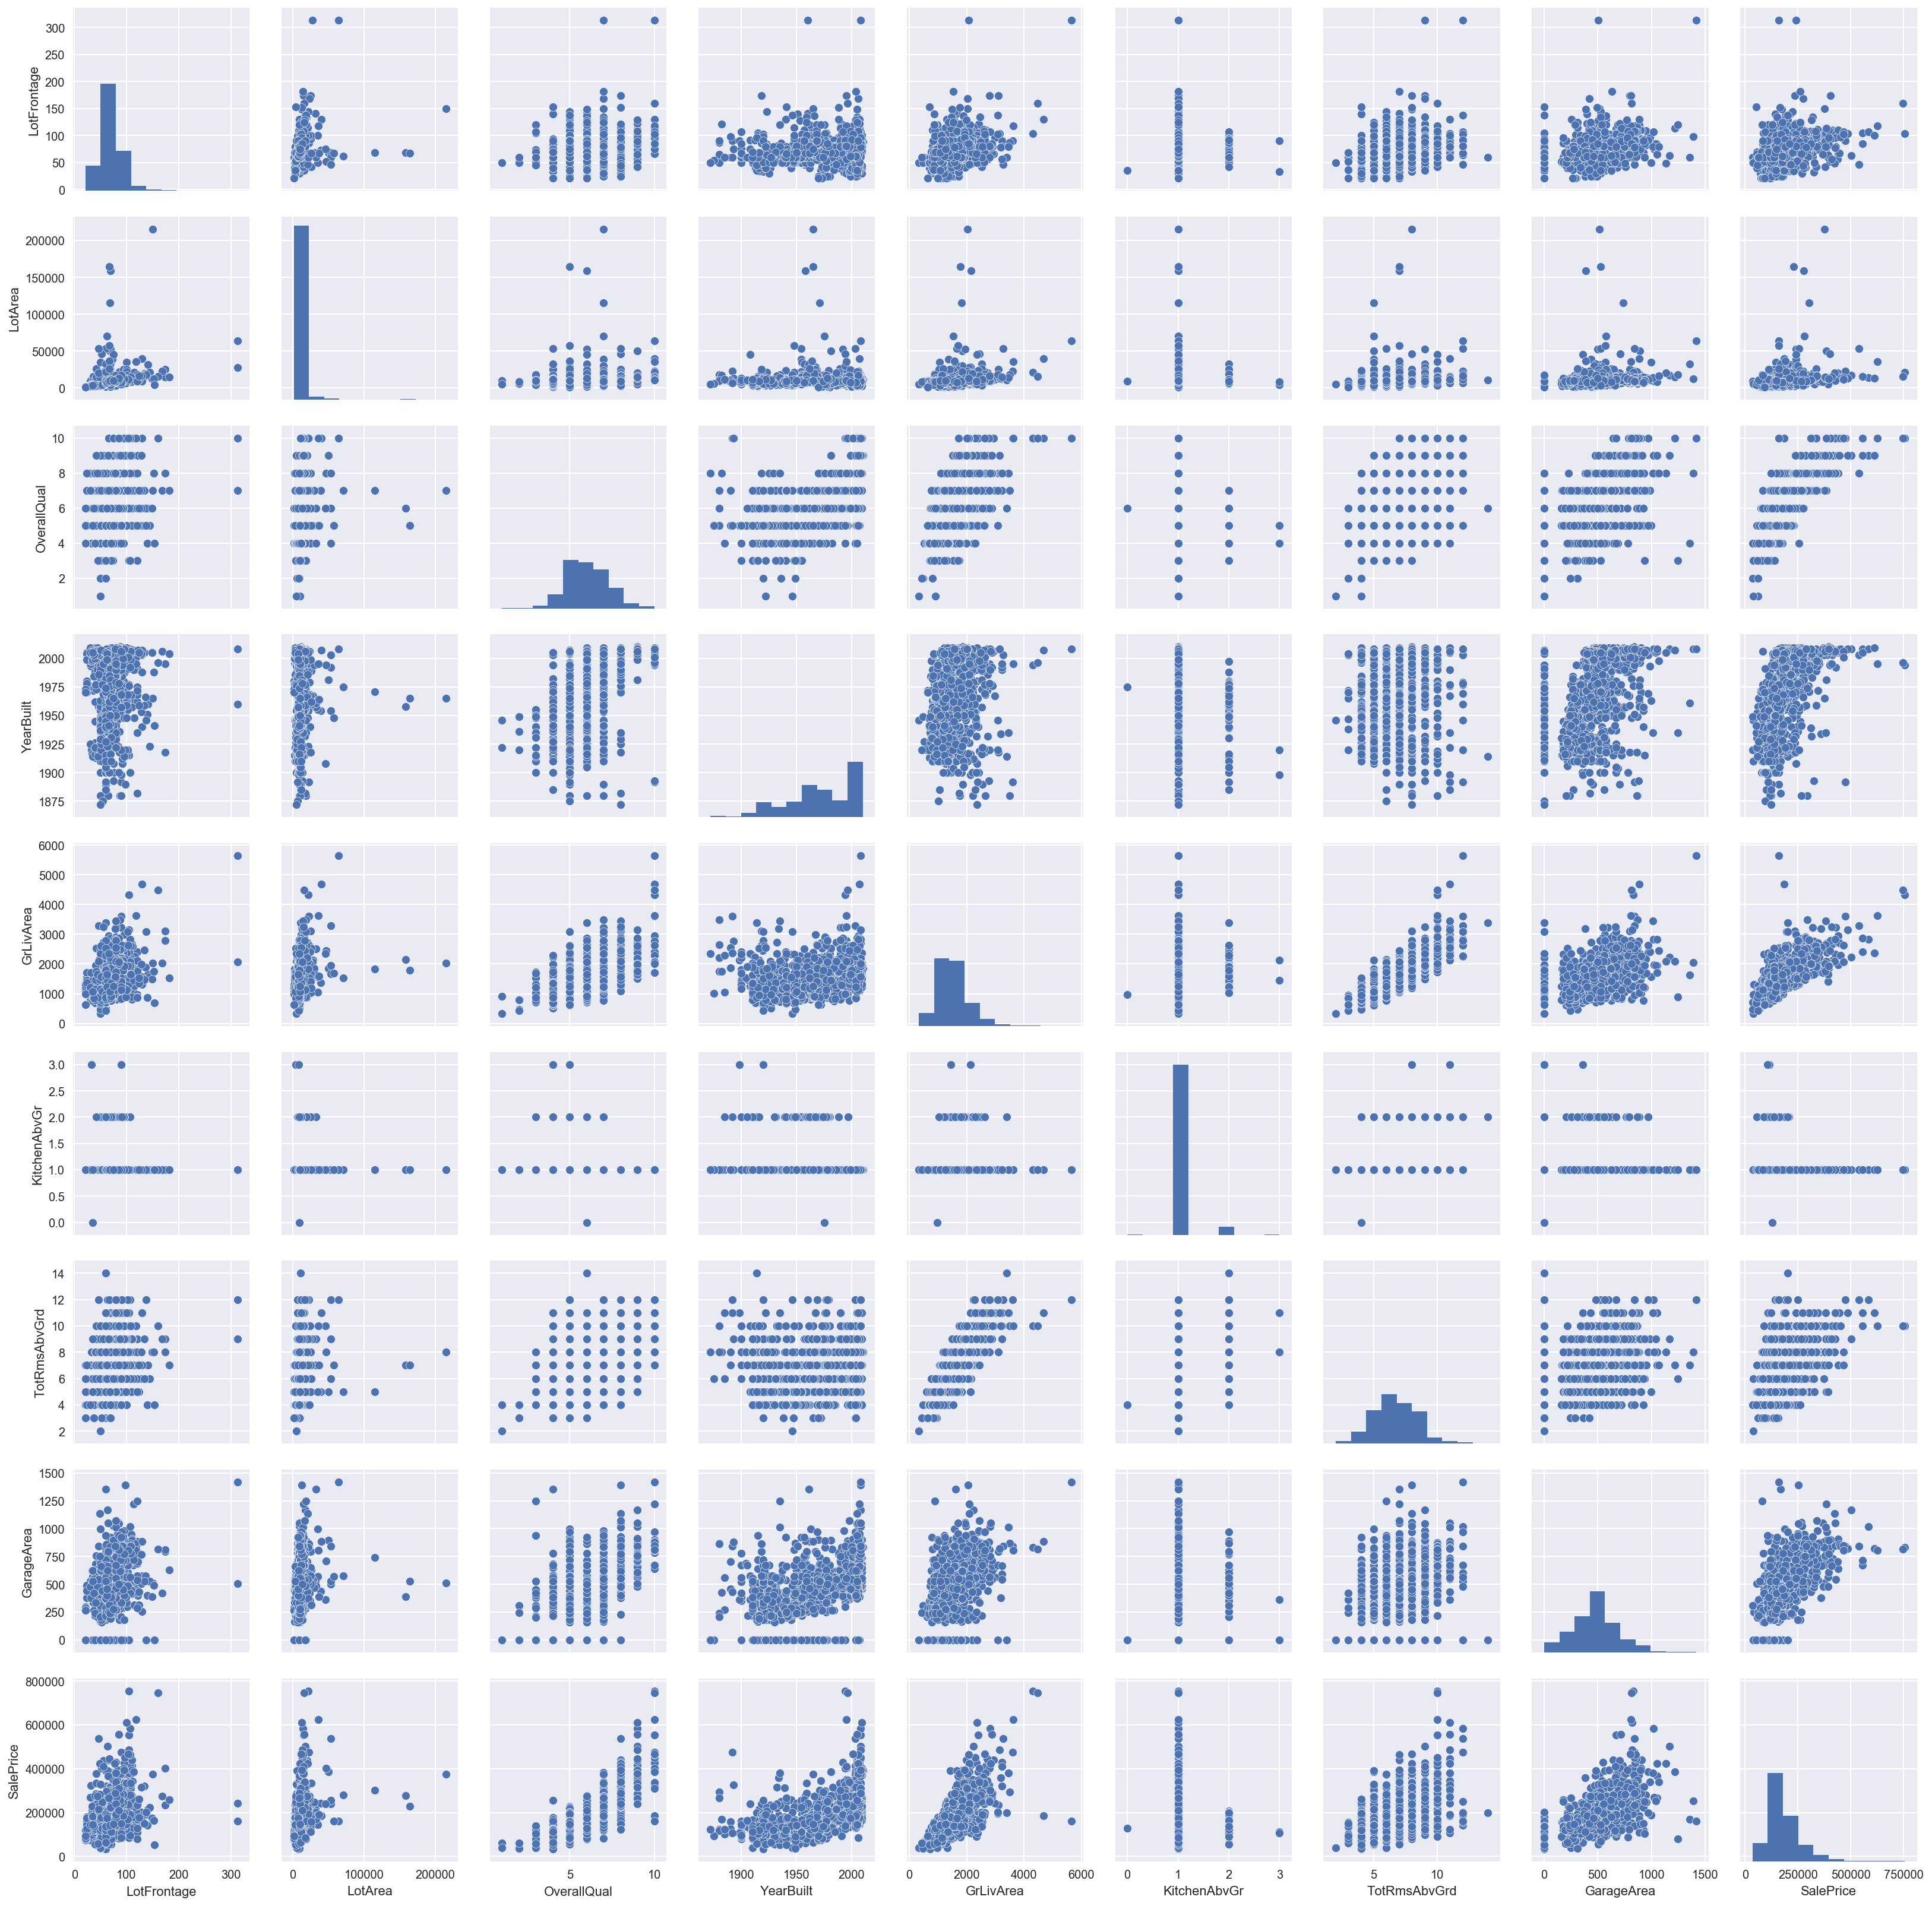

In [130]:
sns.pairplot(train)
plt.show()

## 去掉离群点

In [131]:
train = train[train['LotFrontage'] < train['LotFrontage'].quantile(0.99)]
train = train[train['LotArea'] < train['LotArea'].quantile(0.99)]
train = train[train['GarageArea'] < train['GarageArea'].quantile(0.99)]

In [132]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
result1 = ss.fit_transform(train['LotFrontage'].values.reshape(-1, 1))

In [133]:
result2 = stats.zscore(train['LotFrontage']).reshape(-1,1)

In [134]:
train['LotFrontage'].shape

(1415,)

In [135]:
np.sum(result1 == result2)

1415

In [136]:
# 每一列做标准化处理
for i in train.columns:
    train[i] = stats.zscore(train[i])

In [137]:
X = train.drop('SalePrice',axis=1)
y = train.SalePrice

## 线性回归模型

In [181]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(
    base_score=.5,
    colsample_bylevel=1,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.01,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    missing=None,
    n_estimators=500,
    nthread=-1,
    objective='reg:linear',
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=1850,
    silent=True,
    subsample=1)

In [182]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    xgbr, X, y, scoring='neg_mean_squared_error', cv=10, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished


In [183]:
scores.mean()

-0.16061555883007872

In [173]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}
grid_xgbr = GridSearchCV(
    xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=1)

In [174]:
grid_xgbr.fit(X, y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   14.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1850,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [176]:
grid_xgbr.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [175]:
grid_xgbr.best_score_

-0.15576205326021794

## Tests to determine the Linear Regression model's accuracy

In [31]:
from statsmodels.stats.api import linear_rainbow

model = sm.OLS(y,x).fit()
linear_rainbow(model)[1]

0.9999910092414378

P value > 0.05 hence Reject Null - the data follows a linearity.

In [32]:
from scipy.stats import shapiro
shapiro(model.resid)[1]

1.7575765838579485e-29

In [34]:
from statsmodels.stats.api import het_goldfeldquandt

het_goldfeldquandt(y,x)[1]

0.9858913624243562

P value > 0.05 hence Reject Null - the data is heteroscedastic.

## MODEL 2 - Decision Tree

In [35]:
x = train.drop('SalePrice',axis=1)
y = train.SalePrice

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [37]:
DTR = DecisionTreeRegressor()

In [38]:
model = DTR.fit(x,y)

In [39]:
DTR.predict(x)

array([ 0.42292377,  0.05719636,  0.62610566, ...,  1.20856042,
       -0.47615611, -0.40334927])

In [40]:
r2_score(y,DTR.predict(x))

0.9999570236001247

In [41]:
metrics.mean_absolute_error(y,DTR.predict(x))

0.0006215722620806107

In [42]:
metrics.mean_squared_error(y,DTR.predict(x))

4.297639987524888e-05

In [43]:
np.sqrt(metrics.mean_squared_error(y,DTR.predict(x)))

0.006555638784683677

效果这么好啊，是过拟合了吗？

## MODEL 3 -Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
x = train.drop('SalePrice',axis=1)
y = train.SalePrice

In [46]:
RFR = RandomForestRegressor(n_estimators=100)

In [47]:
model = RFR.fit(x,y)

In [48]:
RFR.predict(x)

array([ 0.40665391, -0.05119441,  0.60715827, ...,  1.01940607,
       -0.61101566, -0.43999651])

In [49]:
r2_score(y,RFR.predict(x))

0.9779415290523968

In [50]:
metrics.mean_absolute_error(y,RFR.predict(x))

0.09804701698044223

In [51]:
metrics.mean_squared_error(y,RFR.predict(x))

0.022058470947603163

In [52]:
np.sqrt(metrics.mean_squared_error(y,RFR.predict(x)))

0.14852094447451902

## Preparing the Test dataset

In [54]:
Id = test['Id']
test.drop(
    [
        'Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature',
        'MSSubClass', 'MSZoning', 'Street', 'Utilities', 'LotShape',
        'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'YearRemodAdd',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
        'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenQual', 'GarageCond', 'Functional',
        'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
        'GarageCars', 'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
    ],
    axis=1,
    inplace=True)

In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
LotFrontage     1232 non-null float64
LotArea         1459 non-null int64
OverallQual     1459 non-null int64
YearBuilt       1459 non-null int64
GrLivArea       1459 non-null int64
KitchenAbvGr    1459 non-null int64
TotRmsAbvGrd    1459 non-null int64
GarageArea      1458 non-null float64
dtypes: float64(2), int64(6)
memory usage: 91.3 KB


In [56]:
for i in test['OverallQual'].unique():
    test['LotFrontage'][(test['LotFrontage'].isnull()) & (test['OverallQual'] == i)] = \
    test['LotFrontage'].groupby(test['OverallQual']==i).median()[1]

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
test['GarageArea'][test['GarageArea'].isnull()] = test['GarageArea'].median()

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Now predicting the values for test using model 2(Decision Tree)


In [58]:
DTR = DecisionTreeRegressor()

In [59]:
model = DTR.fit(x,y)

In [60]:
SalePrice=DTR.predict(test)

In [61]:
final = pd.DataFrame({'Id':Id,'SalePrice':SalePrice})

In [62]:
final.head()

,Id,SalePrice
0,1461,7.825517
1,1462,7.825517
2,1463,7.825517
3,1464,7.825517
4,1465,7.825517


In [63]:
final.to_csv("DecisionTreeRegression.csv",index=False)